<font size="10"> **DSCI project Jun(Yeon Jun) Ahn**</font>

<font size="5"> **Introduction**</font>

This project aims to determine whether patients can be classified correctly for potential heart disease based on their health condition.


High cholesterol creates deposits in the blood vessels, potentially leading to heart disease(Mayo Clinic, 2023). Insulin resistance is when organs cannot absorb sugar from the blood, causing people to have high blood sugar levels. If sugar is not absorbed, the arteries become harder and cause high blood pressure, leading to heart disease (Cleveland Clinic, 2021). Therefore, people with high blood pressure are more prone to have heart disease.


Using the heart disease data - Cleveland, a new patient's potential heart disease(num) can be predicted via their cholesterol, resting blood pressure and maximum heart rate. The knn algorithm predicts the new patient's heart disease status in this project. 


The Heart Disease databases are from https://archive.ics.uci.edu/dataset/45/heart+disease (Janosi, A. et al. 1988).  
The data collected are from 4 locations: Cleveland, Hungary, Switzerland, and VA Long Beach.

For this particular project, a data frame from Cleveland was chosen. 

The data frames consist of the patient's health record separated into 14 different columns:  

1.**age**  
2.**sex**: 0 = female, 1 = male  
3.**chest pain type(cp)**: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic  
4.**resting blood pressure (trestbps)**: in mmHg  
5.**serum cholesterol(chol)**: in mg/dl  
6.**fasting blood sugar > 120 mg/dl (fbs)**: (0 = False, 1 = True)  
7.**resting electrocardiographic results(restecg)**: (0 = normal,1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)  
8.**maximum heart rate achieved(thalach)**: BPM  
9.**exercise-induced angina(exang)**: (0 = no, 1 = yes)  
10.**oldpeak**: ST depression induced by exercise relative to rest  
11.**slope**: the slope of the peak exercise ST segment, 1 = upsloping, 2 = flat, 3 = downsloping  
12.**ca**: number of major vessels(0~3) coloured by florosopy  
13.**thal**   
14.**num**: diagnosis of heart disease; 0 = absent 1 ~ 4 = severity  


In [1]:
library(tidyverse)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
url<-"https://raw.githubusercontent.com/junahn09/project/main/data/heart_disease/processed.cleveland.data" # dataset read in csv in R and assigning columns names.

cleveland_data<-read_csv(url, col_names=c("age","sex","cp","trestbps","chol", "fbs", "restecg",
                                          "thalach", "exang","oldpeak","slope","ca","thal","num"))|> 
                         mutate(sex = as_factor(sex))|># usage of as_factor to change the type of each column (wrangling).
mutate(cp = as_factor(cp))|>
mutate(fbs = as_factor(fbs))|>
mutate( restecg= as_factor(restecg))|>
mutate(exang=as_factor(exang))|>
mutate(slope = as_factor(slope))|>
mutate(thal=as_factor(thal))|>
mutate(num=as_factor(num))|>
mutate(num=fct_recode(num, "negative"="0", #usage of mutate and fct_recode function to change the values of the 'num' variables
                      "positive"="1", 
                      "positive"="2", 
                      "positive"="3", 
                      "positive"="4")) 



cleaned_data <- cleveland_data|> # getting rid of all the values with "?"
filter(!ca == '?')|>
filter(!cp == '?')|>
filter(!trestbps == '?')|>
filter(!chol == '?')|>
filter(!fbs == '?')|>
filter(!restecg == '?')|>
filter(!thalach == '?')|> 
filter(!exang == '?')|>
filter(!oldpeak == '?')|>
filter(!slope == '?')|>
filter(!num == '?')|>
filter(!thal =='?')
cleaned_data

tidy_data<-cleaned_data|> #tidy data by selecting desired columns and arranging it in descending order of thalach column.
select (trestbps, chol, thalach, num)|>
arrange(desc(thalach))
tidy_data


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<chr>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,negative
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,positive
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,positive
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,negative
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,negative
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,negative
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,positive
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,negative
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,positive


trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<fct>
130,204,202,negative
192,283,195,positive
120,240,194,negative
118,210,192,negative
118,186,190,negative
130,219,188,negative
130,250,187,negative
122,222,186,negative
140,261,186,negative


<font size="3"> **Figure 1**</font>

Both table above shows data collected from Cleveland. First table is raw data containing "?" as values in the frame. The second table shows a tidy verstion of the table with selected variables for the prediction with proper type of variables, from dbl to factor as each numerical value represents categorical meaning in num column. Also all the observations with the "?" values are eliminated. Also using mutate and fct_recode function, all the values of the num variable is now changed to negative (0=absent) and positive (1~4=has heart disease)


In [3]:
set.seed(2024) #spliting selected data from above to training (75%) and testing (25%) and getting glimpse for training and testing datas. 

split_data<-initial_split(tidy_data, prop = 0.75, strata=num)
heart_training<-training(split_data)
heart_testing<-testing(split_data)

glimpse(heart_training)

glimpse(heart_testing)


Rows: 222
Columns: 4
$ trestbps <dbl> 120, 118, 130, 130, 115, 128, 140, 138, 120, 130, 130, 112, 1…
$ chol     <dbl> 240, 210, 219, 250, 260, 205, 321, 183, 157, 245, 233, 250, 1…
$ thalach  <dbl> 194, 192, 188, 187, 185, 184, 182, 182, 182, 180, 179, 179, 1…
$ num      <fct> negative, negative, negative, negative, negative, negative, n…
Rows: 75
Columns: 4
$ trestbps <dbl> 130, 118, 122, 140, 120, 138, 115, 140, 130, 120, 140, 130, 1…
$ chol     <dbl> 204, 186, 222, 261, 231, 271, 303, 235, 253, 236, 226, 236, 2…
$ thalach  <dbl> 202, 190, 186, 186, 182, 182, 181, 180, 179, 178, 178, 174, 1…
$ num      <fct> negative, negative, negative, negative, positive, negative, n…


<font size="3"> **Figure 2**</font>

Figure 2 shows initial split of the cleaned data into training (75%) and testing (25%) and glimpse of of training and testing data. set.seed function is used for the random reproduction in set value, 2024. 

In [4]:
heart_training_summary<-heart_training|> # creating a summarized table of selected columns grouped by num and fbs
group_by(num)|>
summarize(max_chol=max(chol), min_chol=min(chol), avg_chol=mean(chol),
          max_trestbps=max(trestbps), min_trestbps=min(trestbps), avg_trestbps=mean(trestbps),
         max_thalach=max(thalach), min_thalach=min(thalach), avg_thalach=mean(thalach))
    

heart_training_summary

num,max_chol,min_chol,avg_chol,max_trestbps,min_trestbps,avg_trestbps,max_thalach,min_thalach,avg_thalach
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
negative,564,126,242.5750,180,94,128.7500,194,96,157.0250
positive,407,149,249.6961,192,100,132.3529,195,71,140.2745


<font size="3"> **Figure 3**</font>

Using group_by and summarize function to calculate statistical values and summarize the subgroups' values in the training set.  
The table above shows the summary of the training data, grouped by 'num':

negative: 0 = absent of heart disease
positive: 1 ~ 4 = Disease with different severity.  

It also show the maximum, minimum, and average values of each column; chol, trestbps, and thalach. 

Patients with no heart disease has the lowest average cholesterol and resting blood pressure. However, it has the highest average maximum heart rate. 

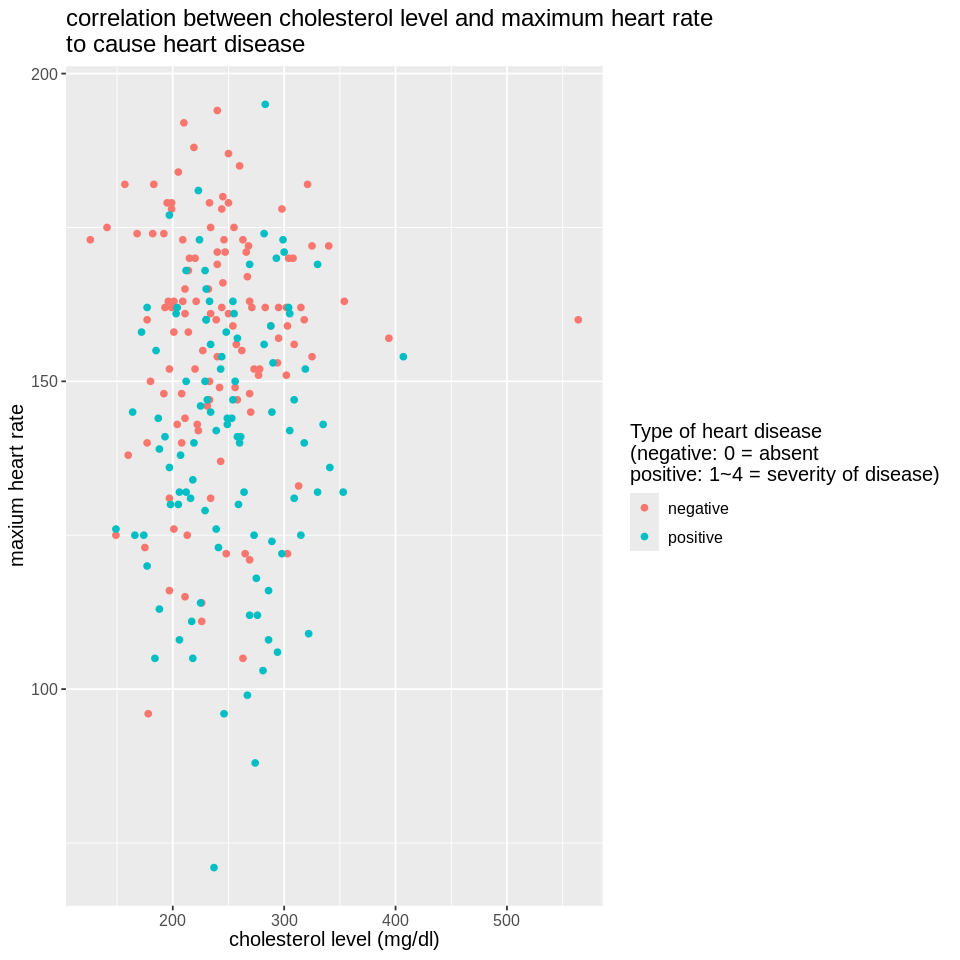

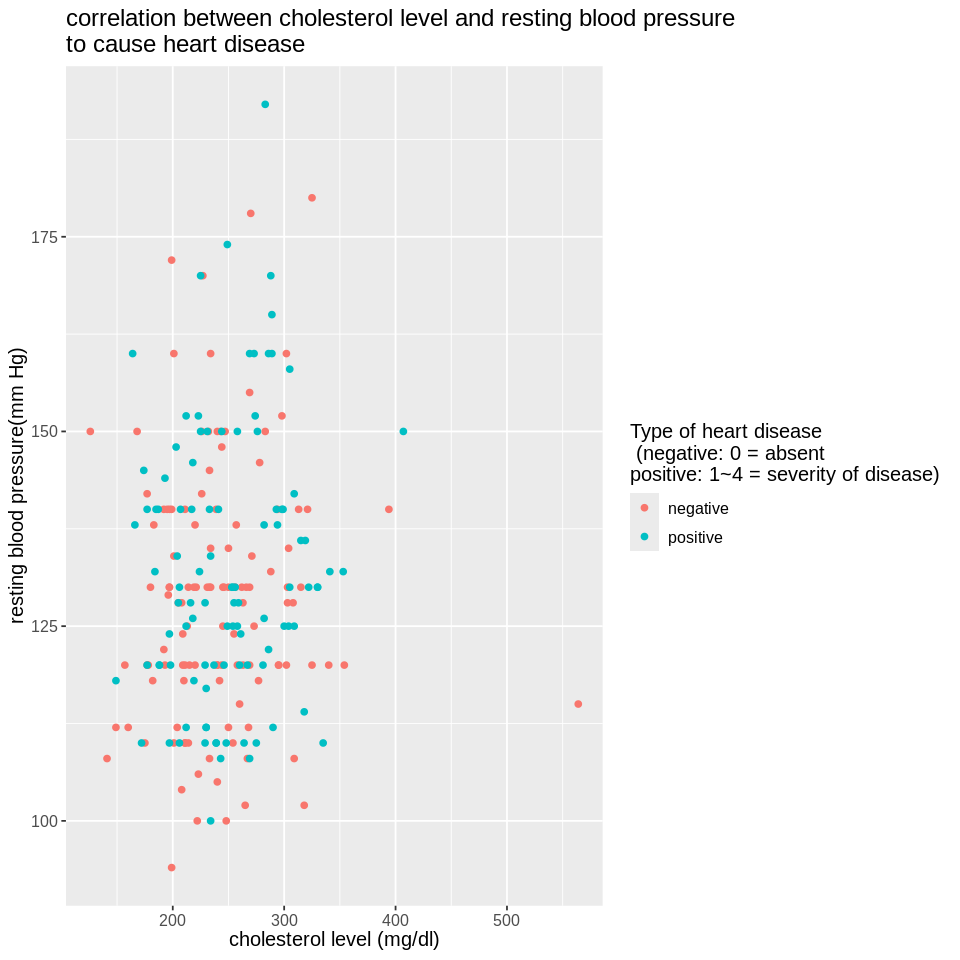

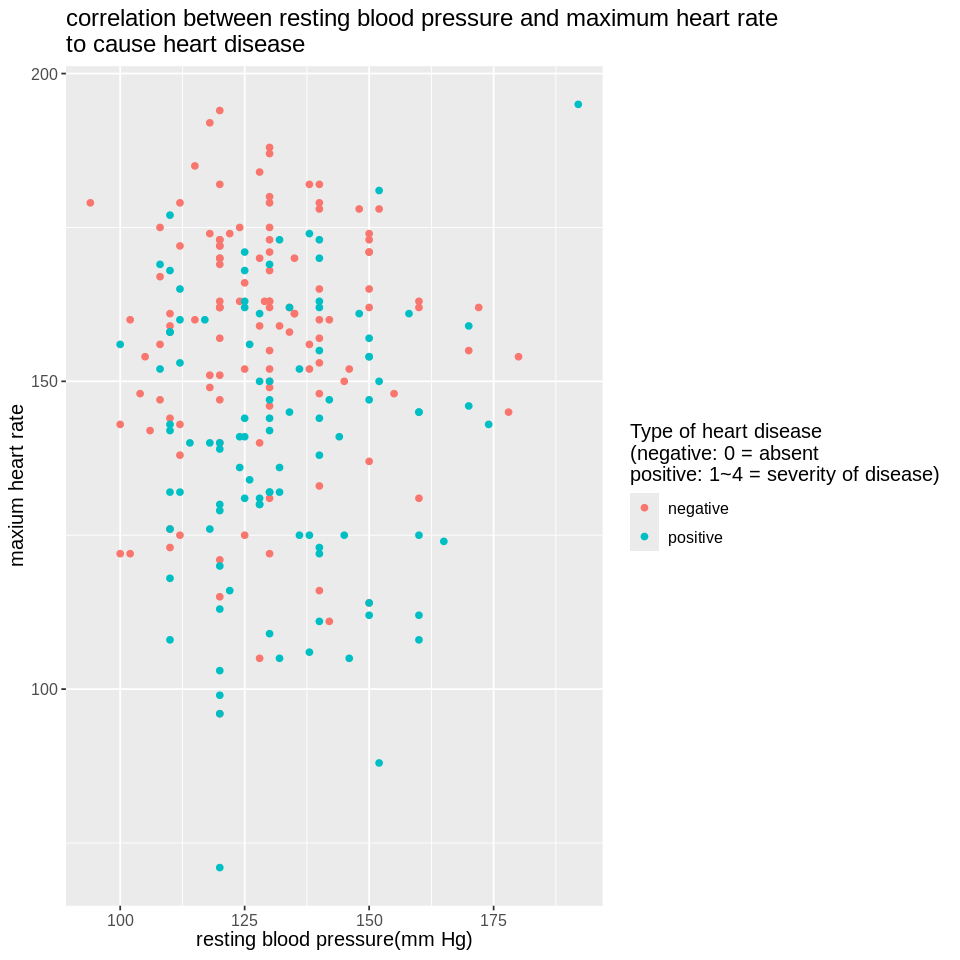

In [5]:
#visualization of data between chol, thalach, and trestbps in scatterplot.

options(repr.plot.width = 8, repr.plot.height = 8)

chol_vs_thalach_plot<-heart_training|>
ggplot(aes(x= chol, y = thalach, colour = num))+
geom_point(aes(colour=factor(num)))+
labs(x = "cholesterol level (mg/dl)", y = "maxium heart rate", 
     title = "correlation between cholesterol level and maximum heart rate \nto cause heart disease",
    colour = "Type of heart disease\n(negative: 0 = absent \npositive: 1~4 = severity of disease)")+
theme(text=element_text(size=12))

chol_vs_thalach_plot

chol_vs_trestbps_plot<-heart_training|>
ggplot(aes(x = chol, y = trestbps, colour = num))+
geom_point(aes(colour=factor(num)))+
           labs(x = "cholesterol level (mg/dl)", y = "resting blood pressure(mm Hg)", 
     title = "correlation between cholesterol level and resting blood pressure \nto cause heart disease",
    colour = "Type of heart disease\n (negative: 0 = absent \npositive: 1~4 = severity of disease)")+
           theme(text=element_text(size=12))
chol_vs_trestbps_plot


trestbps_vs_thalach_plot<-heart_training|>
ggplot(aes(x = trestbps, y = thalach, colour = num))+
geom_point(aes(colour=factor(num)))+
           labs(x = "resting blood pressure(mm Hg)", y = "maxium heart rate", 
     title = "correlation between resting blood pressure and maximum heart rate \nto cause heart disease",
    colour = "Type of heart disease\n(negative: 0 = absent \npositive: 1~4 = severity of disease)")+
           theme(text=element_text(size=12))
trestbps_vs_thalach_plot



<font size="3"> **Figure 4**</font>

Figure 4 contains 3 different plots, each showing the correlations between cholesterol and maximum heart rate, cholesterol and resting blood pressure, and maximum heart rate and resting blood pressure. It also shows the trends of heart disease status in each plot. 

Figure 3 has been visualized in Figure 4 via scatter plot, with distinctive colours representing the absence or presence of  heart disease. Also, potential outliers are detected in the plot, which can affect the statistically calculated values.  


In [6]:
#data analysis: finding the best K value. 

#standardization of data
cleveland_recipe<-recipe(num~., data = heart_training)|>
step_center(all_predictors())|>
step_scale(all_predictors())

#K-nearest neighbor model creating using tune(). 
cleveland_spec<-nearest_neighbor(weight_func = "rectangular", neighbor=tune())|>
set_engine("kknn")|>
set_mode("classification")


#Cross Validation of 10 folds 
vfold<-vfold_cv(heart_training, v=10, strata = num)

k_val<-tibble(neighbors = c(1:100))

#Workflow using tune_grid and collect metric to filter accuracy to determine the best K value.  
knn_results<-workflow()|>
add_recipe(cleveland_recipe)|>
add_model(cleveland_spec)|>
tune_grid(resamples = vfold, grid = k_val)|>
collect_metrics()|>
filter(.metric == "accuracy")

knn_results_summary<-knn_results|>
arrange(desc(mean))|>
head()
knn_results_summary


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
53,accuracy,binary,0.6893281,10,0.03718917,Preprocessor1_Model053
54,accuracy,binary,0.6893281,10,0.03718917,Preprocessor1_Model054
63,accuracy,binary,0.6893281,10,0.03718917,Preprocessor1_Model063
64,accuracy,binary,0.6893281,10,0.03718917,Preprocessor1_Model064
67,accuracy,binary,0.6893281,10,0.03593337,Preprocessor1_Model067
68,accuracy,binary,0.6893281,10,0.03593337,Preprocessor1_Model068


<font size="3"> **Figure 5**</font>

Table of collected metric of k values from training data frame. This table shows only values containing 'accuracy' in .metric variable. Mean has the highest value, 68.9%, when k are 53, 54, 63, 64, 67, and 68.


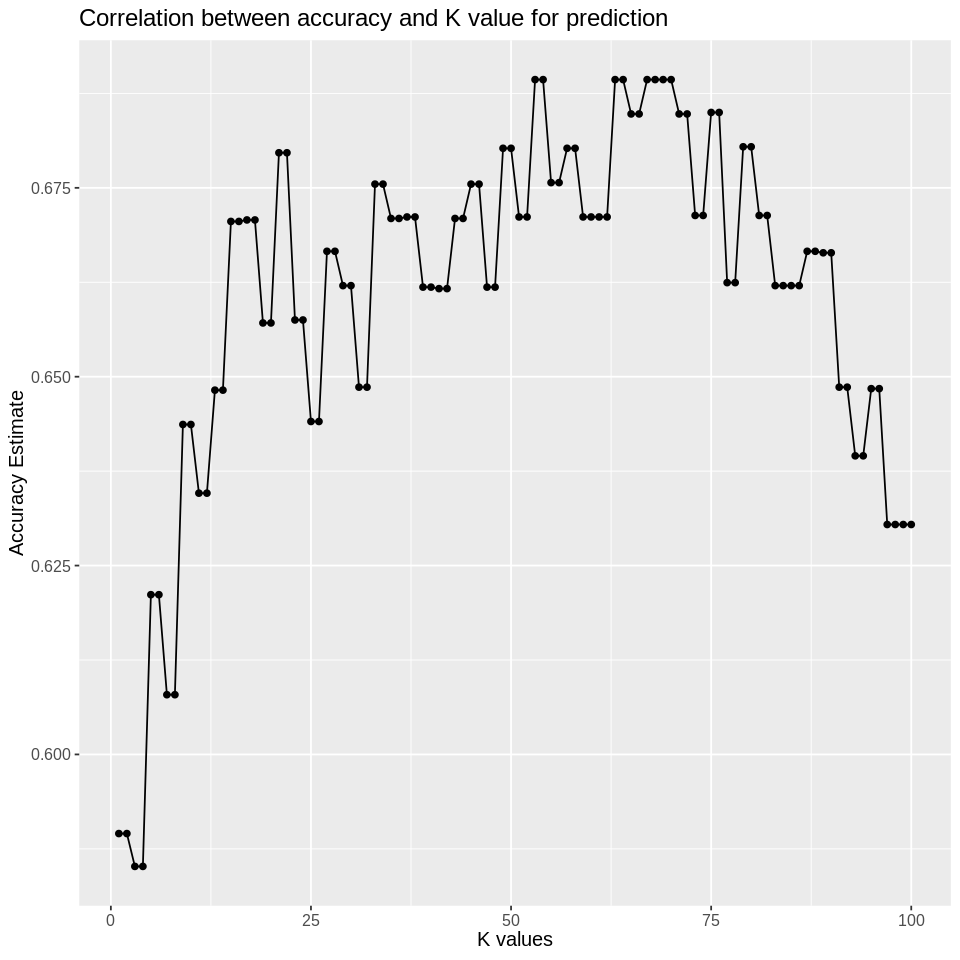

In [7]:
#visualizing and determinating best K value.
options(repr.plot.width=8, repr.plot.height=8)
accuracy_plot<-knn_results|>ggplot(aes(x= neighbors, y = mean))+
geom_point()+
geom_line()+
labs(x="K values",y="Accuracy Estimate",title="Correlation between accuracy and K value for prediction")+
theme(text=element_text(size=12))
accuracy_plot

<font size="3"> **Figure 6**</font>

A plot of K values ranging from 1 to 100 and accuracy estimates. Since when K are at 55 and 56 have the highest peak and have the same value, the best K value for this project would be 53, 54, 63, 64, 67, and 68. Since we must pick only one value, k = 53 was chosen for the testing data frame. 


In [12]:
#Evaluating on the test set
set.seed(2024)

#Creating k nearest neighbor model with best k value, 55
best_spec<-nearest_neighbor(weight_func="rectangular", neighbor = 53)|>
set_engine("kknn")|>
set_mode("classification")

#creating a new workflow using the new classifier model using best k value.
knn_fit<-workflow()|>
add_recipe(cleveland_recipe)|>
add_model(best_spec)|>
fit(data=heart_training)

knn_fit



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(53,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3243243
Best kernel: rectangular
Best k: 53

<font size="3"> **Figure 7**</font>

heart_training was retrained using the best K value, 55. 

In [13]:
#prediction
heart_disease_predictions<-predict(knn_fit, heart_testing)|>
bind_cols(heart_testing)

#finding accuracy in prediction
accuracy<-heart_disease_predictions|>
metrics(truth = num, estimate =.pred_class)|>
filter(.metric == "accuracy")
accuracy

#finding precision in prediction
precision<-heart_disease_predictions|>
precision(truth = num, estimate =.pred_class, even_class ="first")
precision

#confusion matrix
confusion<-heart_disease_predictions|>
conf_mat(truth=num, estimate=.pred_class)
confusion


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7466667


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7333333


          Truth
Prediction negative positive
  negative       33       12
  positive        7       23

<font size="3"> **Figure 8**</font>

The first table shows the prediction accuracy on testing data, 75%, and the second table's prediction precision, 73%. 
The last table is a confusion matrix, indicating 56 correct diagnoses of 75, 75% accuracy. 12 were overdiagnosed, and 7 were underdiagnosed. 


In [39]:
#Testing the prediction model via Switzerland data

url<-"https://raw.githubusercontent.com/UBC-DSCI/dsci-100-project_template/main/data/heart_disease/processed.switzerland.data" # dataset read in csv in R and assigning columns names.

switz_data<-read_csv(url, col_names=c("age","sex","cp","trestbps","chol", "fbs", "restecg",
                                          "thalach", "exang","oldpeak","slope","ca","thal","num"))|> 
                         mutate(sex = as_factor(sex))|># usage of as_factor to change the type of each column (wrangling).
mutate(cp = as_factor(cp))|>
mutate(fbs = as_factor(fbs))|>
mutate( restecg= as_factor(restecg))|>
mutate(exang=as_factor(exang))|>
mutate(slope = as_factor(slope))|>
mutate(thal=as_factor(thal))|>
mutate(num=as_factor(num))|>
mutate(num=fct_recode(num, "negative"="0", #usage of mutate and fct_recode function to change the values of the 'num' variables
                      "positive"="1", 
                      "positive"="2", 
                      "positive"="3", 
                      "positive"="4"))
switz_data

switz_clean<-switz_data|>
mutate(trestbps=fct_recode(trestbps,"NA"="?"))|>
mutate(thalach=fct_recode(thalach,"NA"="?"))|>
select(trestbps, chol, thalach, num)|>
arrange(desc(thalach))|>
head()
switz_clean



Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal
dbl (5): age, sex, cp, chol, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<chr>,<dbl>,<fct>,<fct>,<chr>,<fct>,<chr>,<fct>,<chr>,<fct>,<fct>
32,1,1,95,0,?,0,127,0,.7,1,?,?,positive
34,1,4,115,0,?,?,154,0,.2,1,?,?,positive
35,1,4,?,0,?,0,130,1,?,?,?,7,positive
36,1,4,110,0,?,0,125,1,1,2,?,6,positive
38,0,4,105,0,?,0,166,0,2.8,1,?,?,positive
38,0,4,110,0,0,0,156,0,0,2,?,3,positive
38,1,3,100,0,?,0,179,0,-1.1,1,?,?,negative
38,1,3,115,0,0,0,128,1,0,2,?,7,positive
38,1,4,135,0,?,0,150,0,0,?,?,3,positive


trestbps,chol,thalach,num
<fct>,<dbl>,<fct>,<fct>
145,0,99,positive
155,0,99,positive
160,0,99,positive
125,0,98,positive
160,0,98,positive
185,0,98,positive


<font size="3"> **Figure 9**</font>

Loading and tidying Switzerland data to test the prediction model created from the Cleveland.

In [40]:
#Adding new data with known values and known heart disease status
#randomly chosen first observation 130, 204, 202, negative.  

new_patient <- tibble(trestbps = 145, chol = 0, thalach = 99)


new_fit <- workflow() |>
          add_recipe(cleveland_recipe) |>
          add_model(best_spec) |>
          fit(data = heart_training)

pred_test<-predict(new_fit, new_patient) #predict
pred_test

patient_2<-tibble(trestbps = 155, chol = 0, thalach = 99) #second test with second observation.

fit_2<-workflow() |>
          add_recipe(cleveland_recipe) |>
          add_model(best_spec) |>
          fit(data = heart_training)

test_2<-predict(fit_2, patient_2)
test_2

patient_3<-tibble(trestbps = 160 , chol = 0 , thalach = 99 )

fit_3<-workflow() |>
          add_recipe(cleveland_recipe) |>
          add_model(best_spec) |>
          fit(data = heart_training)

test_3<-predict(fit_3, patient_3)
test_3


.pred_class
<fct>
positive


.pred_class
<fct>
positive


.pred_class
<fct>
positive


<font size="3"> **Figure 10**</font>

Ran three random tests with three "new" patients for accuracy. The three patients' data were collected from the Switzerland data frame with known heart disease status. All the patients have heart disease and the classification model predicted correctly.

<font size="6"> **Methods**</font>

Using library function, tidyverse and tidymodels were installed in R to load, clean, wrangle, visualize, and classify.  

First the data from the Internet was converted using its web address, https://raw.githubusercontent.com/junahn09/project/main/data/heart_disease/processed.cleveland.data, and saved as a URL. The URL was read in R using the read_csv and the column names were assigned to their corresponding values. Some variable types were changed according to the original source. Using mutate and as_factor functions from dbl to fct, as some variables had numerical values to represent categorical values.  

The values found as '?' were eliminated using the filter function to clean the data frame. This resulted in 297 observations and 14 variables in the data frame. Also, using mutate and fct_recode function, all the numerical values of absent or present heart disease and its severity in 'num' variable were changed to positive(1~4 = severity of heart disease) and negative (0 = absent). 

To tidy the data, the select and arrange functions were used to select only the 'num', 'thalach', 'trestbps', and chol columns, organizing them in descending order of 'thalach'. These variables were selected because each value was specific to each patient's health condition. Since there are standardized ranges of a healthy person's maximum heart rate, resting heart rate, and cholesterol level, these variables were chosen to predict the potential of having heart disease.  

The set.seed function was used for reproducible analysis, with a value of 2024. Then, the data was separated into training and testing data via the initial_split function(75% training and 25% testing), followed by training and testing functions. 

Then, it was summarized into a table. The table grouped the data using the group_by function via 'num' and the summarize function to collect the rest of the selected columns' maximum, minimum, and average values. 

The scatter plot was chosen to visualize as all the selected variables represented numerical values corresponding to each observation(patients). The ggplot function assigned each axis between maximum heart rate(thalach), resting heart rate(restbps), and cholesterol(chol). Using aesthetic function in ggplot, different colours represented different values of 'num'. 

For R to graph scatter plot, the geom_point function was used for all three thalach vs. restbps, thalach vs. chol, and restbps vs. chol. The scatter plot's aesthetic was assigned via 'aes(colour=factor(num))' to match the ggplot.

The title, name of the axis, and legend title were assigned via the labs function.

Then, the best k value was determined by first standardizing the values via step_center and step_scale in the recipe function to ensure the values have the same ranges. 

To find the best k value, the k-nearest neighbour model was created using nearest_neighbor function. The 'weight_func' and 'neighbor' corresponded to "rectangular" and 'tune()'. The engine was set for 'kknn', and the mode was 'classification'. 

For the cross-validation, the training data were split into 10 validation sets using the vfold_cv function, v = 10 and strata = num, as predictions are to be made based on whether the patient has a heart disease or not. 

To use tune_grid in the workflow() to fit the model to each value, k_val data was created, testing all the k values from 1 to 100. 

In the workflow() function, cleveland_recipe and cleveland_spec were added as recipe and model, then tune grid using vfold and k_val as their resamples and grid. Using the collect metrics(), filter, arrange, and head() functions, the first 6 values of data containing 'accuracy' were created in descending order of the metrics table (Figure 5). 

As Figure 6 shows, the plot of k values from 1 ~ 100 vs accuracy estimate was created using ggplot, geom_point, and geom_line. The highest peak of the graph is the best k value. 

Once the model was built, the data was tested using the best k value via recipe and a classifier model with the best k value and workflow. Then, using predict and bind_cols functions, the testing data was tested with the newly created model.  

Metrics and filter functions were used to view the accuracy and precision of the prediction. 

The conf_mat function created a confusion matrix to visualize the prediction easily. 

Three random data points were selected to test the model's prediction accuracy with known values from another dataset, Switzerland.  


<font size="6"> **Discussion**</font>

**summarize what you found**

After splitting the data into training (75%) and testing (25%), the best K value was found, 53 (or 53, 54, 63, 64, 67, and 68 as they had the same accuracy values) by comparing the accuracy estimate to potential best K values from 1 to 200 via standardizing the values, cross-validation, and tuning the model. 

After testing the best k value on the testing data to predict whether a person would have heart disease based on the following patients' conditions: resting blood pressure, maximum heart rate, and cholesterol level, the classifier model was predicted with 75% accuracy and a precision of 73%. According to the confusion matrix, 12 were overdiagnosed, and seven were underdiagnosed out of 75. 

Also, when the model was tested with the three patients' known values from Switzerland, including heart disease status, all three heart disease statuses were predicted correctly. 

**Discuss whether this is what you expected to find.**

A person with abnormal cholesterol levels, resting blood pressure, and maximum heart rate are expected to have heart disease, and the classifier model is expected to predict whether the person has heart disease.

Also, the prediction model should be highly accurate (above 80%) since three variables from the original data frame contribute highly to heart disease: cholesterol level, resting blood pressure, and maximum heart rate. 

The prediction model's accuracy is 75%, less than expected. This could be due to the sample size not being large enough, the outliers not being eliminated, and the lack of complexity of the model with more variables. 

When visually compared, people with and without heart disease were expected to cluster separately. However, the plots mostly overlap between the two groups (with and without the disease). Again, this could be improved by having larger data values and/or adding more variables to the prediction.  

**discuss what impact could such findings have?**

Using other patients' data to create a predictive program for potential heart disease could delay or prevent the disease. This may prolong human life expectancy by being proactive and allowing pharmaceutical companies to develop suitable medicines early in the disease.

Also, in this model, the prediction was simply whether the person had the disease; however, if the model could consider the severity, doctors could diagnose more accurately and treat with more appropriate procedures. 

**Discuss what future questions could this lead to?**

Perhaps in the future, people can question whether any other factors in life contribute to heart disease or are there any relation between diet, origin, race, smoking status, genetic markers, etc.

<font size="6"> **Reference**</font>

1. Mayo Clinic (2023). High Cholesterol - Symptoms and Causes. https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/symptoms-causes/syc-20350800.
2. Cleveland Clinic (2021). Insulin Resistance. https://my.clevelandclinic.org/health/diseases/22206-insulin-resistance.
3. Janosi, A., Steinbrunn, W, Pfisterer, M., and Detrano. R. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.
 
